# Problem Statement

Car Data-
Here, we will apply k-means clustering for grouping the similar cars in one cluster

In [1]:
#Import all the necessary modules
#Import all the necessary modules
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
#Import all the necessary modules
import pandas as pandas
import numpy as numpy
import os
import matplotlib.pyplot as matplot
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
import itertools
from IPython.display import Image  
from os import system
numpy.random.seed(1234)
RandomState = 1234
from scipy.stats import zscore
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.grid_search import GridSearchCV

# Overall Approach

1. Perform EDA - Understand the data, Treat missing value, univariate and bivariate analysis, Treat outliers
2. Perform clustering to determine Gaussian Mixtures
3. Feature engineering and selection
4. Model building and evaluation

# Custom functions for EDA

In [2]:
def EDA_Corr(df):
    corr = df.corr()
    index = corr.columns
    Output = []
    for i in range(0,len(index)):
        i = index[i]
        Pos = corr.index[(corr[i] >= 0.5)].tolist()
        No = corr.index[(corr[i] < 0.5) & (corr[i] > -0.6)].tolist()
        Neg = corr.index[(corr[i] <= -0.5)].tolist()
        leng_u = len(No)
        leng_pos = len(Pos)
        leng_neg = len(Neg)
        Out = [i, leng_u, leng_pos, leng_neg, Pos, Neg, No]
        Output.append(Out)
    fig, ax = matplot.subplots(figsize=(20,10))  
    sns.heatmap(corr,annot=True,vmin=-1,vmax=1,cmap='Blues', linewidths=0, ax = ax)
    Output1 = pandas.DataFrame(Output, columns= ['Feature','Uniqueness','Positive rel', 'inverse rel', 'Pos', 'Neg', 'No'])
    return Output1

def EDA(df):
    EDA = pandas.DataFrame((df.describe()).T)
    EDA["Kurtosis"] = df.kurtosis()
    EDA["Skewness"] = df.skew()
    EDA["Range"] = EDA['max'] -  EDA['min']
    EDA["IQR"] = EDA['75%'] -  EDA['25%']
    return EDA

# Importing Data Set

In [3]:
Source = pandas.read_csv("cars-dataset.csv")

In [4]:
Source.head(10)

,car name,cyl,disp,hp,wt,acc,yr,mpg
0,chevrolet chevelle malibu,8,307.0,130,3504,12.0,70,18.0
1,buick skylark 320,8,350.0,165,3693,11.5,70,15.0
2,plymouth satellite,8,318.0,150,3436,11.0,70,18.0
3,amc rebel sst,8,304.0,150,3433,12.0,70,16.0
4,ford torino,8,302.0,140,3449,10.5,70,17.0
5,ford galaxie 500,8,429.0,198,4341,10.0,70,15.0
6,chevrolet impala,8,454.0,220,4354,9.0,70,14.0
7,plymouth fury iii,8,440.0,215,4312,8.5,70,14.0
8,pontiac catalina,8,455.0,225,4425,10.0,70,14.0
9,amc ambassador dpl,8,390.0,190,3850,8.5,70,15.0


# Exploratory Data Analysis - Data Wrangling and Preprocessing

Approach Taken
1. Analyse 5 pont summary, Kurtosis, Skewness and Range
2. Analyse the distribution of the data for each variable
3. Analyse outliers using Box plot
4. Infer the results and assess the impact 


In [5]:
Source.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
car name    398 non-null object
cyl         398 non-null int64
disp        398 non-null float64
hp          398 non-null object
wt          398 non-null int64
acc         398 non-null float64
yr          398 non-null int64
mpg         398 non-null float64
dtypes: float64(3), int64(3), object(2)
memory usage: 25.0+ KB


In [6]:
Source.shape

(398, 8)

In [8]:
(Source.iloc[:0:7])[~(Source.iloc[:0:7]).applymap(numpy.isreal).all(1)]

,car name,cyl,disp,hp,wt,acc,yr,mpg


In [9]:
Source['hp'] = Source['hp'].replace('?',0)
Source['hp'] = Source['hp'].replace('?',Source['hp'].median())

In [10]:
Source.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
car name    398 non-null object
cyl         398 non-null int64
disp        398 non-null float64
hp          398 non-null object
wt          398 non-null int64
acc         398 non-null float64
yr          398 non-null int64
mpg         398 non-null float64
dtypes: float64(3), int64(3), object(2)
memory usage: 25.0+ KB


In [11]:
Source['hp'] = pandas.to_numeric(Source['hp'])

In [12]:
Source.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
car name    398 non-null object
cyl         398 non-null int64
disp        398 non-null float64
hp          398 non-null int64
wt          398 non-null int64
acc         398 non-null float64
yr          398 non-null int64
mpg         398 non-null float64
dtypes: float64(3), int64(4), object(1)
memory usage: 25.0+ KB


In [13]:
EDA_results = EDA(Source)
EDA_results

,count,mean,std,min,25%,50%,75%,max,Kurtosis,Skewness,Range,IQR
cyl,398.0,5.454774,1.701004,3.0,4.000,4.0,8.000,8.0,-1.376662,0.526922,5.0,4.00
disp,398.0,193.425879,104.269838,68.0,104.250,148.5,262.000,455.0,-0.746597,0.719645,387.0,157.75
hp,398.0,102.894472,40.269544,0.0,75.000,92.0,125.000,230.0,0.844941,0.787889,230.0,50.00
wt,398.0,2970.424623,846.841774,1613.0,2223.750,2803.5,3608.000,5140.0,-0.785529,0.531063,3527.0,1384.25
acc,398.0,15.568090,2.757689,8.0,13.825,15.5,17.175,24.8,0.419497,0.278777,16.8,3.35
yr,398.0,76.010050,3.697627,70.0,73.000,76.0,79.000,82.0,-1.181232,0.011535,12.0,6.00
mpg,398.0,23.514573,7.815984,9.0,17.500,23.0,29.000,46.6,-0.510781,0.457066,37.6,11.50


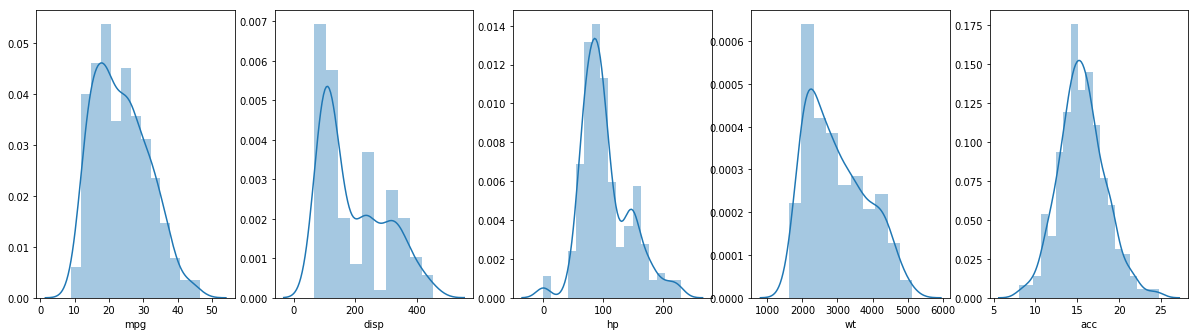

In [14]:
f, axes = matplot.subplots(1, 5, figsize=(8, 8))
sns.distplot(Source['mpg'], ax = axes[0])
sns.distplot(Source['disp'], ax = axes[1])
sns.distplot(Source['hp'], ax = axes[2])
sns.distplot(Source['wt'], ax = axes[3])
sns.distplot(Source['acc'], ax = axes[4])
matplot.subplots_adjust(top =  1.5, right = 10, left = 8, bottom = 1)

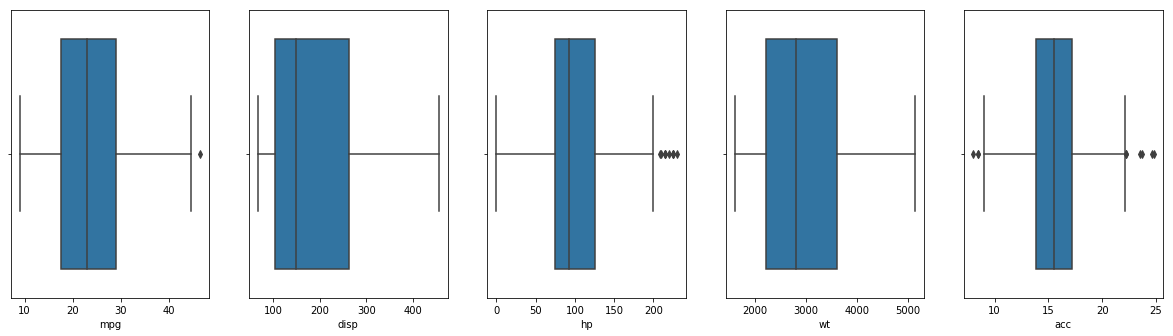

In [15]:
f, axes = matplot.subplots(1, 5, figsize=(8, 8))
sns.boxplot(Source['mpg'], ax = axes[0])
sns.boxplot(Source['disp'], ax = axes[1])
sns.boxplot(Source['hp'], ax = axes[2])
sns.boxplot(Source['wt'], ax = axes[3])
sns.boxplot(Source['acc'], ax = axes[4])
matplot.subplots_adjust(top =  1.5, right = 10, left = 8, bottom = 1)

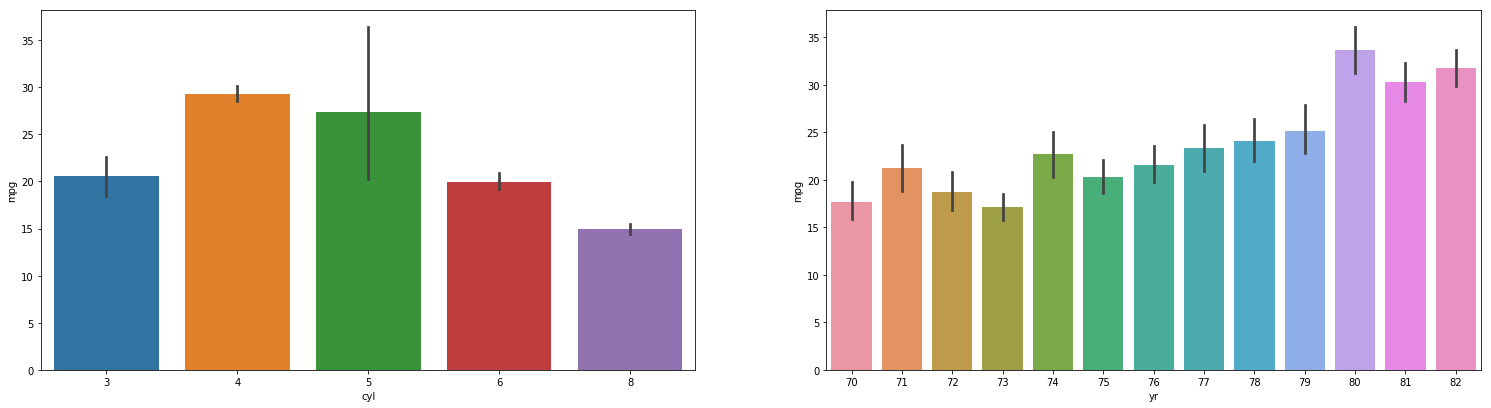

In [16]:
f, axes = matplot.subplots(1, 2, figsize=(10, 10))
sns.barplot(x = 'cyl', y = 'mpg', data = Source, ax = axes[0])
sns.barplot(x = 'yr', y = 'mpg', data = Source, ax = axes[1])
matplot.subplots_adjust(top =  1.5, right = 10, left = 8, bottom = 1)

In [17]:
Source['cyl'].value_counts()

4    204
8    103
6     84
3      4
5      3
Name: cyl, dtype: int64

In [18]:
Source['yr'].value_counts()

73    40
78    36
76    34
82    31
75    30
81    29
80    29
79    29
70    29
77    28
72    28
71    28
74    27
Name: yr, dtype: int64

In [19]:
Source['car name'].value_counts()

ford pinto                           6
amc matador                          5
ford maverick                        5
toyota corolla                       5
chevrolet chevette                   4
amc gremlin                          4
toyota corona                        4
chevrolet impala                     4
amc hornet                           4
peugeot 504                          4
ford galaxie 500                     3
ford gran torino                     3
dodge colt                           3
chevrolet nova                       3
plymouth duster                      3
plymouth fury iii                    3
pontiac catalina                     3
volkswagen dasher                    3
honda civic                          3
chevrolet citation                   3
chevrolet caprice classic            3
chevrolet vega                       3
chevrolet chevelle malibu classic    2
honda accord                         2
subaru dl                            2
toyota mark ii           

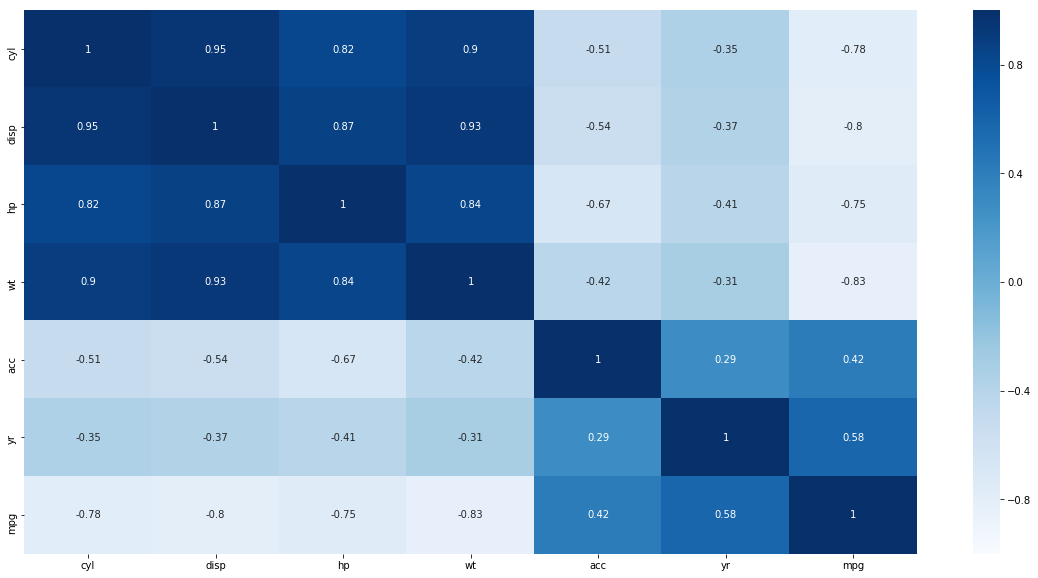

In [20]:
EDA_Corr_Results = pandas.DataFrame(EDA_Corr(Source))

In [21]:
(EDA_Corr_Results.sort_values("Uniqueness", ascending= False)).head()

,Feature,Uniqueness,Positive rel,inverse rel,Pos,Neg,No
4,acc,5,1,3,[acc],"[cyl, disp, hp]","[cyl, disp, wt, yr, mpg]"
5,yr,5,2,0,"[yr, mpg]",[],"[cyl, disp, hp, wt, acc]"
0,cyl,2,4,2,"[cyl, disp, hp, wt]","[acc, mpg]","[acc, yr]"
1,disp,2,4,2,"[cyl, disp, hp, wt]","[acc, mpg]","[acc, yr]"
3,wt,2,4,1,"[cyl, disp, hp, wt]",[mpg],"[acc, yr]"


In [22]:
(EDA_Corr_Results.sort_values("Positive rel", ascending= False)).head()

,Feature,Uniqueness,Positive rel,inverse rel,Pos,Neg,No
0,cyl,2,4,2,"[cyl, disp, hp, wt]","[acc, mpg]","[acc, yr]"
1,disp,2,4,2,"[cyl, disp, hp, wt]","[acc, mpg]","[acc, yr]"
2,hp,1,4,2,"[cyl, disp, hp, wt]","[acc, mpg]",[yr]
3,wt,2,4,1,"[cyl, disp, hp, wt]",[mpg],"[acc, yr]"
5,yr,5,2,0,"[yr, mpg]",[],"[cyl, disp, hp, wt, acc]"


In [23]:
(EDA_Corr_Results.sort_values("Neg", ascending= False)).head()

,Feature,Uniqueness,Positive rel,inverse rel,Pos,Neg,No
3,wt,2,4,1,"[cyl, disp, hp, wt]",[mpg],"[acc, yr]"
6,mpg,1,2,4,"[yr, mpg]","[cyl, disp, hp, wt]",[acc]
4,acc,5,1,3,[acc],"[cyl, disp, hp]","[cyl, disp, wt, yr, mpg]"
0,cyl,2,4,2,"[cyl, disp, hp, wt]","[acc, mpg]","[acc, yr]"
1,disp,2,4,2,"[cyl, disp, hp, wt]","[acc, mpg]","[acc, yr]"


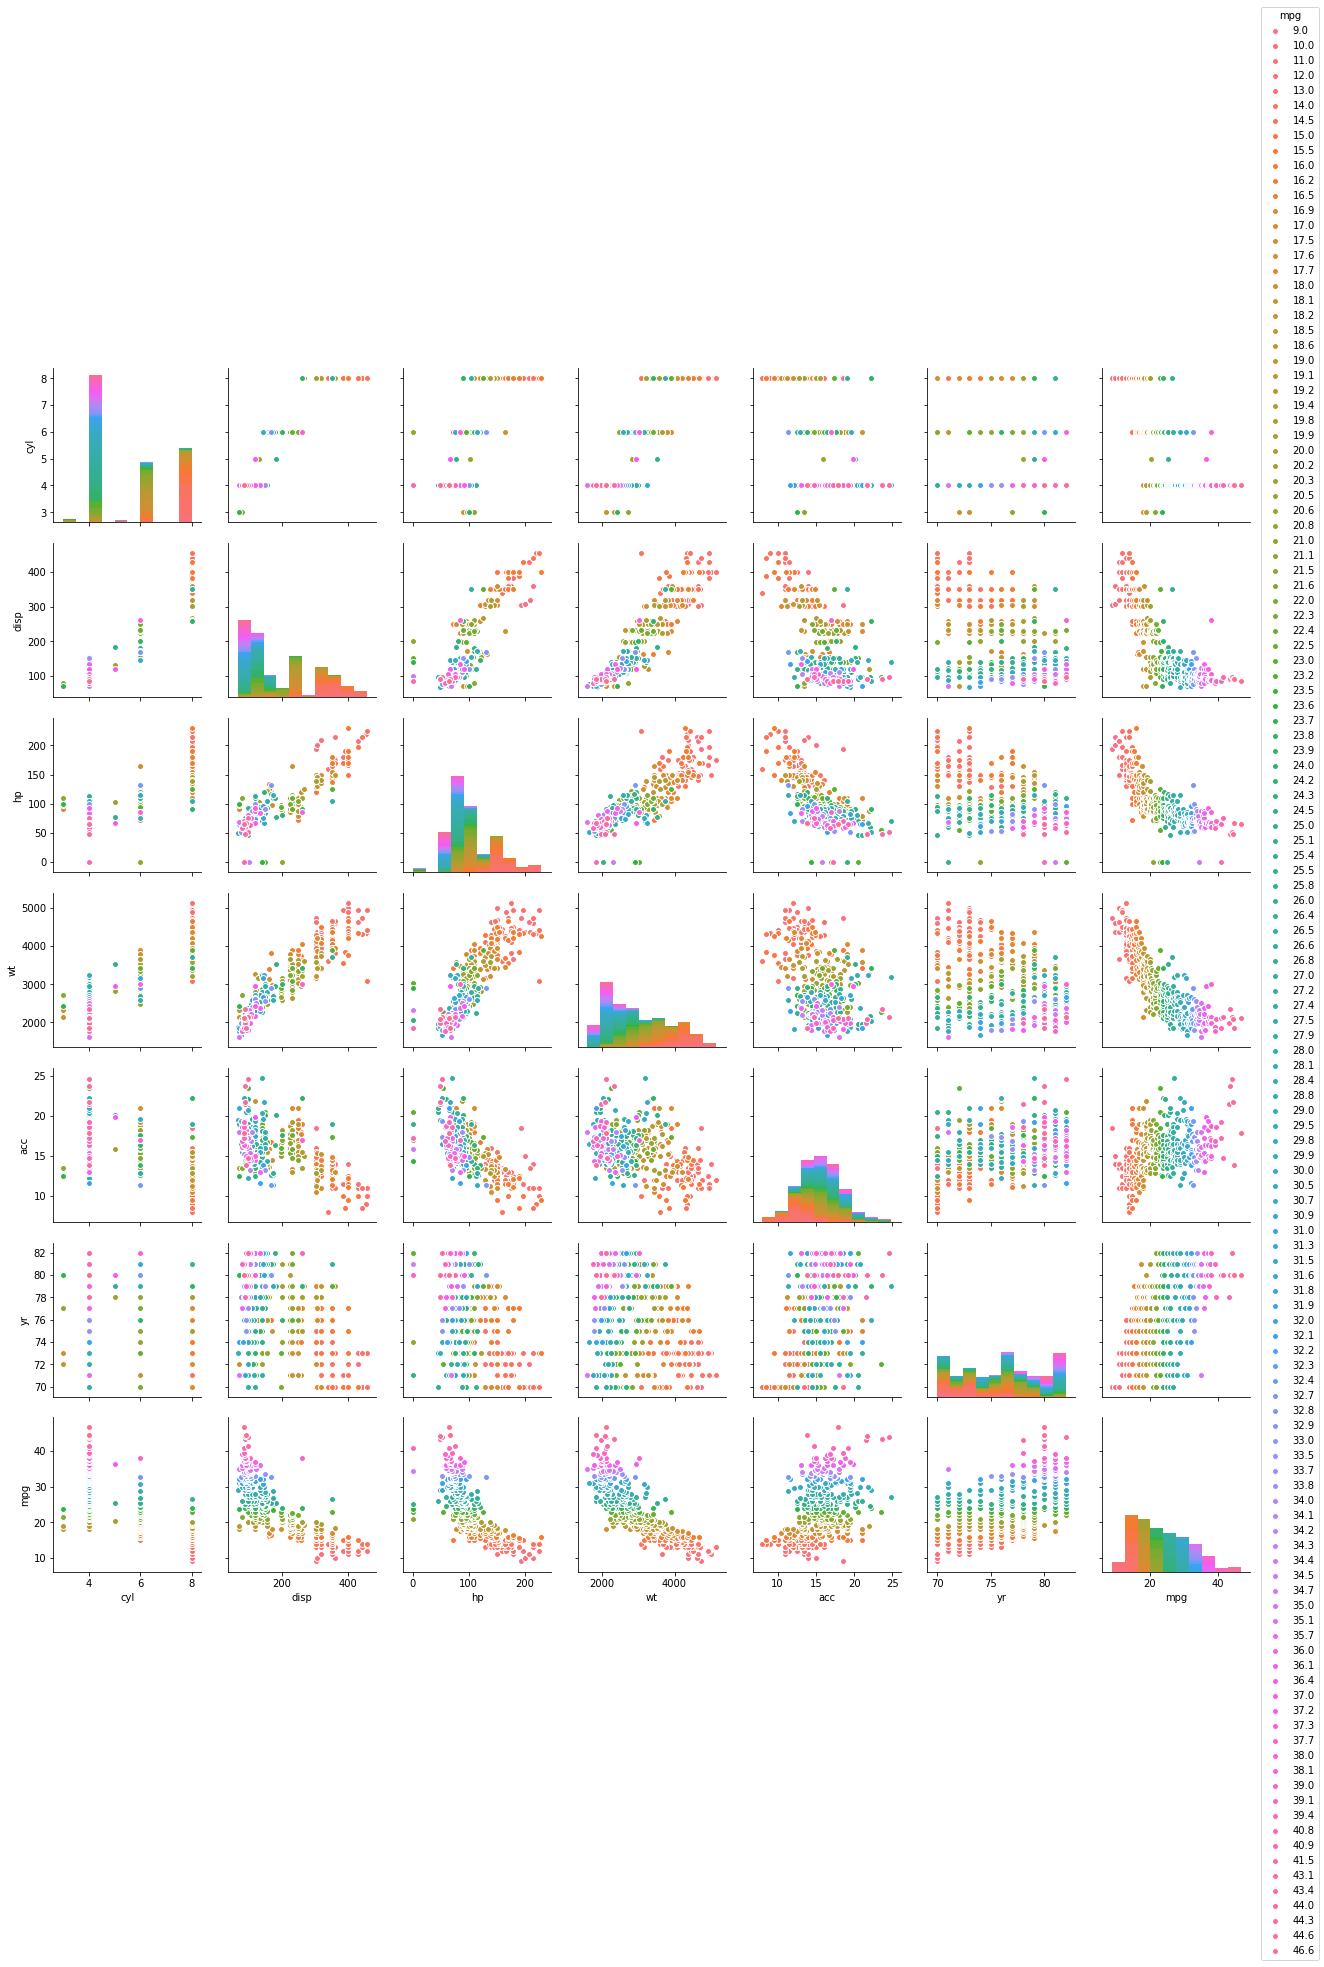

In [24]:
sns.pairplot(Source, hue = 'mpg')

# Feature creation and Outlier treatment

Approach Taken
1. Create new feature
2. Determine outliers
3. Check outlier impact
4. Remove / Impute outliers with appropriate values
5. Scale the data 

In [25]:
Source['Age'] = 83 - Source['yr']

In [26]:
Source.head()

,car name,cyl,disp,hp,wt,acc,yr,mpg,Age
0,chevrolet chevelle malibu,8,307.0,130,3504,12.0,70,18.0,13
1,buick skylark 320,8,350.0,165,3693,11.5,70,15.0,13
2,plymouth satellite,8,318.0,150,3436,11.0,70,18.0,13
3,amc rebel sst,8,304.0,150,3433,12.0,70,16.0,13
4,ford torino,8,302.0,140,3449,10.5,70,17.0,13


In [27]:
Source.columns

Index(['car name', 'cyl', 'disp', 'hp', 'wt', 'acc', 'yr', 'mpg', 'Age'], dtype='object')

In [28]:
Subset = Source[['mpg',  'disp',   'hp','wt', 'acc']]

Subset_Columns = ['mpg',  'disp',   'hp','wt', 'acc']

a = Subset > Subset.quantile(0.75) + ((1.5 * (EDA(Subset))['IQR'])[0:4])
b = Subset < Subset.quantile(0.25) - ((1.5 * (EDA(Subset))['IQR'])[0:4])

Source[["Q31","Q32","Q33","Q34","Q35"]] = a
Source[["Q11","Q12","Q13","Q14","Q15"]] = b

columns = ['Q31', 'Q32', 'Q33', 'Q34', 'Q35']

Q1 =  ['Q11','Q12', 'Q13', 'Q14', 'Q15']

Q3 =  ['Q31', 'Q32', 'Q33', 'Q34', 'Q35']

In [29]:
Q1_Outliers = []
Q1_j = []
Q3_Outliers = []
Q3_j = []
for i in range(0,len(Q1)):
    i = Q1[i]
    No = Source.shape[0] - Source[i].value_counts()[0]
    Q1_Outliers.append(No)
    Q1_j.append(i)
Q1_Col = pandas.DataFrame(Q1_j, columns=["Q1"])
Q1_outliers = pandas.DataFrame(Q1_Outliers, columns=["Q1 Outliers"])
Outliers_impact_Q1 = Q1_Col.join(Q1_outliers)

for i in range(0,len(Q3)):
    i = Q3[i]
    No = Source.shape[0] - Source[i].value_counts()[0]
    Q3_Outliers.append(No)
    Q3_j.append(i)
Q3_Col = pandas.DataFrame(Q3_j, columns=["Q3"])
Q3_outliers = pandas.DataFrame(Q3_Outliers, columns=["Q3 Outliers"])
Outliers_impact_Q3 = Q3_Col.join(Q3_outliers)

Outliers_impact = Outliers_impact_Q1['Q1 Outliers']+Outliers_impact_Q3['Q3 Outliers']
Outliers_impact = (pandas.DataFrame(Subset_Columns, columns=["Column Name"])).join(pandas.DataFrame(Outliers_impact, columns=["No of Outliers"]))

In [30]:
Outliers_impact

,Column Name,No of Outliers
0,mpg,0
1,disp,0
2,hp,10
3,wt,1
4,acc,0


In [31]:
aij = []
for i in range(0,5):
    i = Q3[i]
    bij = ((pandas.DataFrame(Source[i])).index[(Source[i] == True)].tolist())
    aij = aij + bij
Q3_indices = (pandas.Series(aij)).value_counts()


cij = []
for i in range(0,5):
    i = Q1[i]
    dij = ((pandas.DataFrame(Source[i])).index[(Source[i] == True)].tolist())
    cij = cij + dij
Q1_indices = (pandas.Series(cij)).value_counts()

In [32]:
Q3_indices

95     1
94     1
13     1
27     1
25     1
8      1
7      1
6      1
116    1
67     1
322    1
dtype: int64

In [33]:
Q1_indices

Series([], dtype: int64)

In [34]:
Q3_values = Subset.quantile(0.75) + (1.5 * (EDA(Subset))['IQR'])
Q1_values = Subset.quantile(0.25) - (1.5 * (EDA(Subset))['IQR'])
Outliers_Q3_Q1 = pandas.DataFrame(Q3_values, columns = ['Q3_values']).join(pandas.DataFrame(Q1_values, columns=['Q1_values']))
for i in range(0,len(Subset_Columns)):
    Q3 = ((Outliers_Q3_Q1).T)[Subset_Columns[i]].loc['Q3_values']
    Q1 = ((Outliers_Q3_Q1).T)[Subset_Columns[i]].loc['Q1_values']
    Source.loc[Source[Subset_Columns[i]] > Q3, Subset_Columns[i]] = numpy.nan
    Source.loc[Source[Subset_Columns[i]] < Q1, Subset_Columns[i]] = numpy.nan
    median1 = ((Source.loc[(Source[Subset_Columns[i]]<((((Outliers_Q3_Q1).T)[Subset_Columns[i]])['Q3_values'])) & 
             (Source[Subset_Columns[i]]>((((Outliers_Q3_Q1).T)[Subset_Columns[i]])['Q1_values']))])[Subset_Columns[i]]).median()
    Source.replace(numpy.nan,median1,inplace= True)

In [35]:
Source = Source.iloc[:,0:9]

In [36]:
Source.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
car name    398 non-null object
cyl         398 non-null int64
disp        398 non-null float64
hp          398 non-null float64
wt          398 non-null float64
acc         398 non-null float64
yr          398 non-null int64
mpg         398 non-null float64
Age         398 non-null int64
dtypes: float64(5), int64(3), object(1)
memory usage: 28.1+ KB


In [37]:
Source.head()

,car name,cyl,disp,hp,wt,acc,yr,mpg,Age
0,chevrolet chevelle malibu,8,307.0,130.0,3504.0,12.0,70,18.0,13
1,buick skylark 320,8,350.0,165.0,3693.0,11.5,70,15.0,13
2,plymouth satellite,8,318.0,150.0,3436.0,11.0,70,18.0,13
3,amc rebel sst,8,304.0,150.0,3433.0,12.0,70,16.0,13
4,ford torino,8,302.0,140.0,3449.0,10.5,70,17.0,13


In [38]:
minmax_scale = MinMaxScaler()
Source[['mpg',  'disp',   'hp','wt', 'acc']] = minmax_scale.fit_transform(Source[['mpg',  'disp',   'hp','wt', 'acc']])
Source

,car name,cyl,disp,hp,wt,acc,yr,mpg,Age
0,chevrolet chevelle malibu,8,0.617571,0.650,0.536150,0.229008,70,0.252809,13
1,buick skylark 320,8,0.728682,0.825,0.589736,0.190840,70,0.168539,13
2,plymouth satellite,8,0.645995,0.750,0.516870,0.152672,70,0.252809,13
3,amc rebel sst,8,0.609819,0.750,0.516019,0.229008,70,0.196629,13
4,ford torino,8,0.604651,0.700,0.520556,0.114504,70,0.224719,13
5,ford galaxie 500,8,0.932817,0.990,0.773462,0.076336,70,0.168539,13
6,chevrolet impala,8,0.997416,0.460,0.777148,0.000000,70,0.140449,13
7,plymouth fury iii,8,0.961240,0.460,0.765240,0.496183,70,0.140449,13
8,pontiac catalina,8,1.000000,0.460,0.797278,0.076336,70,0.140449,13
9,amc ambassador dpl,8,0.832041,0.950,0.634250,0.496183,70,0.168539,13


In [39]:
Source_Scale = Source

In [40]:
Source_Scale.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
car name    398 non-null object
cyl         398 non-null int64
disp        398 non-null float64
hp          398 non-null float64
wt          398 non-null float64
acc         398 non-null float64
yr          398 non-null int64
mpg         398 non-null float64
Age         398 non-null int64
dtypes: float64(5), int64(3), object(1)
memory usage: 28.1+ KB


In [41]:
Source_Scaled = Source_Scale.drop(['yr','car name'], axis =1)

Source_Scaled.head()

,cyl,disp,hp,wt,acc,mpg,Age
0,8,0.617571,0.650,0.536150,0.229008,0.252809,13
1,8,0.728682,0.825,0.589736,0.190840,0.168539,13
2,8,0.645995,0.750,0.516870,0.152672,0.252809,13
3,8,0.609819,0.750,0.516019,0.229008,0.196629,13
4,8,0.604651,0.700,0.520556,0.114504,0.224719,13


In [42]:
Source_Scaled.shape

(398, 7)

# Create appropriate clusters with the new data set

Approach Taken
1. Choose the appropriate number of clusters, evaluate them using Elbow chart and Silhoutte's score
2. Create clusters using the right number
3. Map the cluster to the 'Source' data set

In [43]:
cluster_range = range( 1, 10)   # expect 3 to four clusters from the pair panel visual inspection hence restricting from 2 to 6
cluster_errors = []
cluster_sil_scores = []
for num_clusters in cluster_range:
  clusters = KMeans( num_clusters, n_init = 5)
  clusters.fit(Source_Scaled)
  labels = clusters.labels_                     # capture the cluster lables
  centroids = clusters.cluster_centers_         # capture the centroids
  cluster_errors.append( clusters.inertia_ )    # capture the intertia
  


# combine the cluster_range and cluster_errors into a dataframe by combining them
clusters_df = pandas.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors} )
clusters_df[0:15]

,cluster_errors,num_clusters
0,6674.150133,1
1,2519.382305,2
2,1681.307583,3
3,1191.521049,4
4,891.082727,5
5,711.886865,6
6,590.737709,7
7,534.146453,8
8,437.590974,9


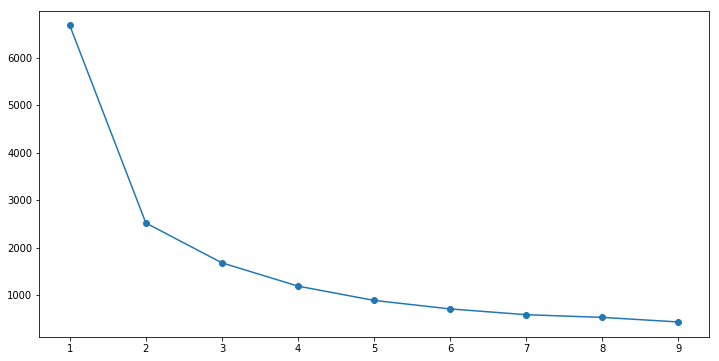

In [44]:
matplot.figure(figsize=(12,6))
matplot.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )

For n_clusters = 2 The average silhouette_score is : 0.505205598780623
For n_clusters = 3 The average silhouette_score is : 0.43212094738251994
For n_clusters = 4 The average silhouette_score is : 0.4413318497569663
For n_clusters = 5 The average silhouette_score is : 0.463713970926365
For n_clusters = 6 The average silhouette_score is : 0.46359133211633585


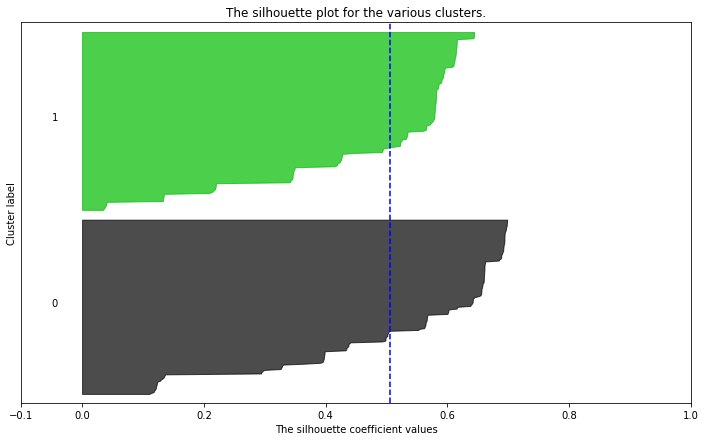

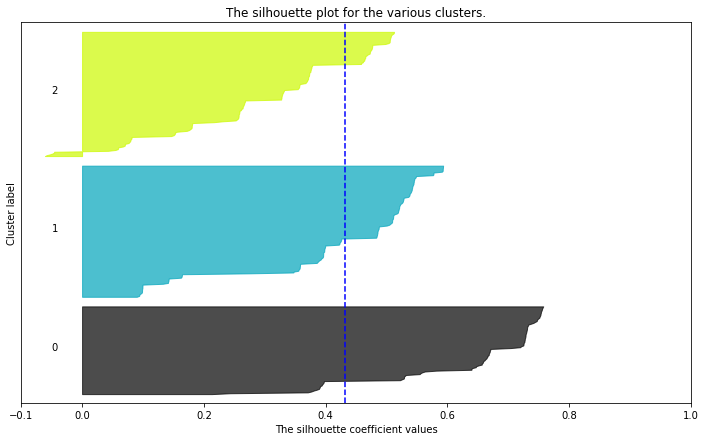

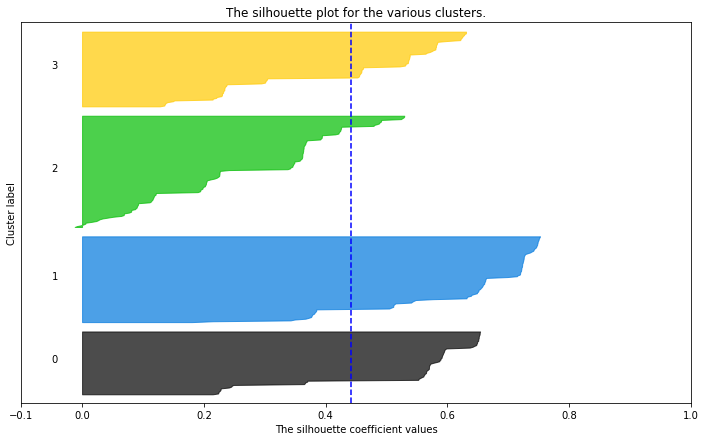

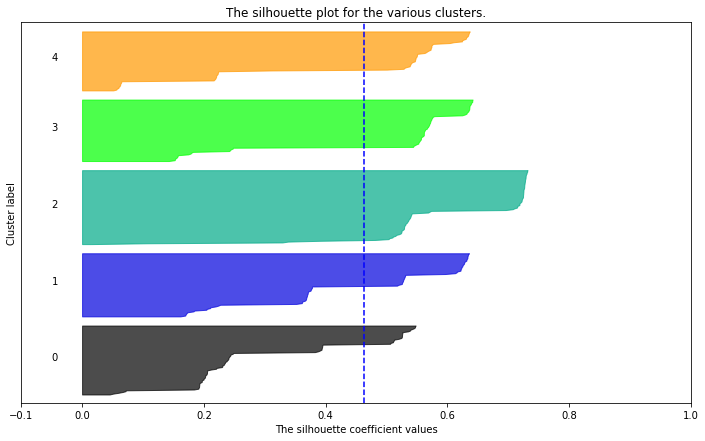

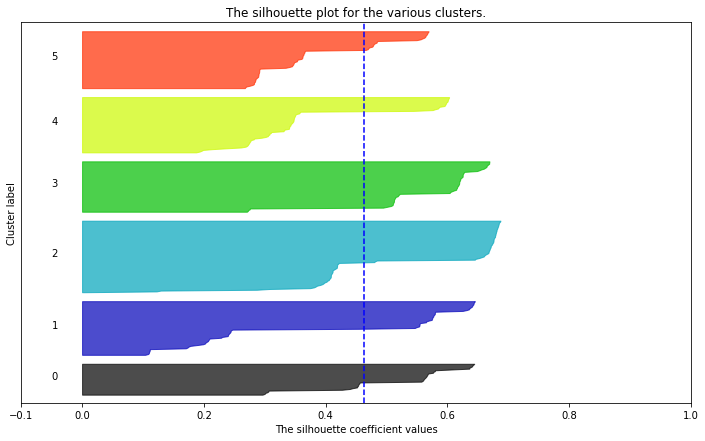

In [45]:
X = Source_Scaled
range_n_clusters = [2, 3, 4,5,6]

for n_clusters in range_n_clusters:
    fig, (ax1) = matplot.subplots(1)
    fig.set_size_inches(12, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(numpy.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="blue", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

matplot.show()

There is no perfect elbow seen in elbow chart except n = 2 clusters. however, given the business problem, 2 doesnt make sense and further analysing both elbow chart and Silhoutte's score, next possible cluster can be n_clusters = 4 as it shows the next best Silhoutte score. Hence cluster 4 may be an ideal number may be an ideal cluster number

In [46]:
kmeans = KMeans(n_clusters=4)
kmeans = kmeans.fit(Source_Scaled)
labels = kmeans.predict(Source_Scaled)
centroids = kmeans.cluster_centers_
print("Centroid values")
print(centroids)

Centroid values
[[ 4.31460674  0.14695294  0.4152809   0.22769454  0.56565743  0.42450448
  10.17977528]
 [ 4.28431373  0.14916147  0.38191176  0.2423406   0.55919772  0.63395021
   2.23529412]
 [ 7.68        0.69681309  0.70466667  0.68299405  0.30636132  0.15393258
  11.38666667]
 [ 5.86363636  0.36694464  0.52768939  0.43158191  0.50884802  0.36074225
   6.01515152]]


In [47]:
prediction= kmeans.predict(Source_Scaled)
Source_Scaled["clusters"] = prediction

In [48]:
Source_Scaled['clusters'].value_counts()

3    132
1    102
0     89
2     75
Name: clusters, dtype: int64

In [49]:
pandas.DataFrame(centroids)

,0,1,2,3,4,5,6
0,4.314607,0.146953,0.415281,0.227695,0.565657,0.424504,10.179775
1,4.284314,0.149161,0.381912,0.242341,0.559198,0.633950,2.235294
2,7.680000,0.696813,0.704667,0.682994,0.306361,0.153933,11.386667
3,5.863636,0.366945,0.527689,0.431582,0.508848,0.360742,6.015152


In [50]:
Source_Scaled.head()

,cyl,disp,hp,wt,acc,mpg,Age,clusters
0,8,0.617571,0.650,0.536150,0.229008,0.252809,13,2
1,8,0.728682,0.825,0.589736,0.190840,0.168539,13,2
2,8,0.645995,0.750,0.516870,0.152672,0.252809,13,2
3,8,0.609819,0.750,0.516019,0.229008,0.196629,13,2
4,8,0.604651,0.700,0.520556,0.114504,0.224719,13,2


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000023EEBD4ADD8>,
      dtype=object)

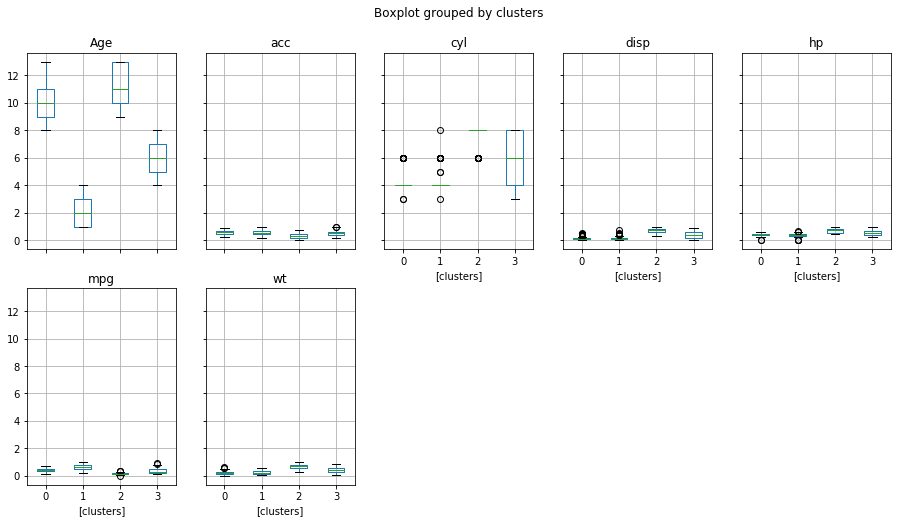

In [51]:
(Source_Scaled.loc[:, Source_Scaled.columns != 'yr']).boxplot(by = 'clusters', figsize=(15,8), layout=(2,5))

# Featurization, Model building and Evaluation

Approach Taken:
1. Since the data has 4 clusters, model building will happen for each of those
2. Choose the right number of features using Sequential forward selection method for each cluster
3. Build model for each cluster
4. Compare results with model without any clusters

In [53]:
Feature_Columns = []

In [54]:
Source_Scaled_1 = Source_Scaled.loc[Source_Scaled['clusters'] == 1]

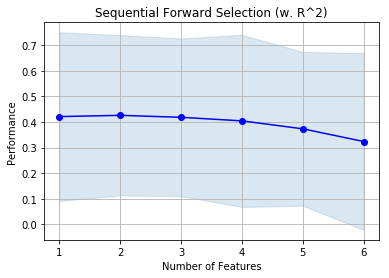

[0, 1, 2, 3, 4, 5]
['cyl', 'disp', 'hp', 'wt', 'acc', 'Age']


In [55]:

Y = pandas.DataFrame(Source_Scaled_1["mpg"])
X = Source_Scaled_1.loc[:, ~Source_Scaled_1.columns.isin(['mpg','clusters'])]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=100)
linR = LinearRegression()
sfs1 = sfs(linR, k_features=6, forward=True, scoring='r2', cv=5)
sfs1 = sfs1.fit(X_train, Y_train)
sfs1.get_metric_dict()
fig = plot_sfs(sfs1.get_metric_dict())
matplot.title('Sequential Forward Selection (w. R^2)')
matplot.grid()
matplot.show()
columnList = list(X_train.columns)
feat_cols = list(sfs1.k_feature_idx_)
print(feat_cols)
subsetColumnList = [columnList[j] for j in feat_cols] 
print(subsetColumnList)
Feature_Columns.append(subsetColumnList)

In [56]:
Feature_Columns.append(1)

In [57]:
Feature_Columns

[['cyl', 'disp', 'hp', 'wt', 'acc', 'Age'], 1]

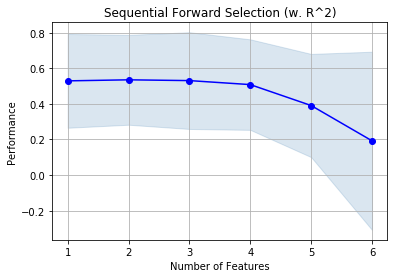

[0, 1, 2, 3, 4, 5]
['cyl', 'disp', 'hp', 'wt', 'acc', 'Age']


In [58]:
Source_Scaled_0 = Source_Scaled.loc[Source_Scaled['clusters'] == 0]
Y = pandas.DataFrame(Source_Scaled_0["mpg"])
X = Source_Scaled_0.loc[:, ~Source_Scaled_0.columns.isin(['mpg','clusters'])]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=100)
linR = LinearRegression()
sfs1 = sfs(linR, k_features=6, forward=True, scoring='r2', cv=5)
sfs1 = sfs1.fit(X_train, Y_train)
sfs1.get_metric_dict()
fig = plot_sfs(sfs1.get_metric_dict())
matplot.title('Sequential Forward Selection (w. R^2)')
matplot.grid()
matplot.show()
columnList = list(X_train.columns)
feat_cols = list(sfs1.k_feature_idx_)
print(feat_cols)
subsetColumnList = [columnList[j] for j in feat_cols] 
print(subsetColumnList)
Feature_Columns.append(subsetColumnList)
Feature_Columns.append(0)

In [ ]:
Feature_Columns

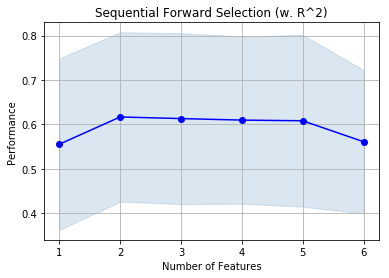

[0, 1, 2, 3, 4, 5]
['cyl', 'disp', 'hp', 'wt', 'acc', 'Age']


In [59]:
Source_Scaled_2 = Source_Scaled.loc[Source_Scaled['clusters'] == 2]
Y = pandas.DataFrame(Source_Scaled_2["mpg"])
X = Source_Scaled_2.loc[:, ~Source_Scaled_2.columns.isin(['mpg','clusters'])]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=100)
linR = LinearRegression()
sfs1 = sfs(linR, k_features=6, forward=True, scoring='r2', cv=5)
sfs1 = sfs1.fit(X_train, Y_train)
sfs1.get_metric_dict()
fig = plot_sfs(sfs1.get_metric_dict())
matplot.title('Sequential Forward Selection (w. R^2)')
matplot.grid()
matplot.show()
columnList = list(X_train.columns)
feat_cols = list(sfs1.k_feature_idx_)
print(feat_cols)
subsetColumnList = [columnList[j] for j in feat_cols] 
print(subsetColumnList)
Feature_Columns.append(subsetColumnList)
Feature_Columns.append(2)

In [60]:
Feature_Columns

[['cyl', 'disp', 'hp', 'wt', 'acc', 'Age'],
 1,
 ['cyl', 'disp', 'hp', 'wt', 'acc', 'Age'],
 0,
 ['cyl', 'disp', 'hp', 'wt', 'acc', 'Age'],
 2]

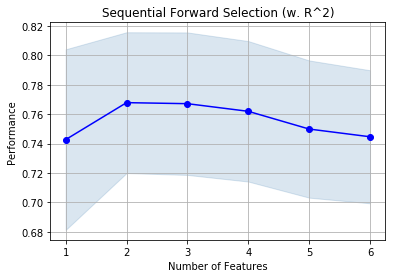

[0, 1, 2, 3, 4, 5]
['cyl', 'disp', 'hp', 'wt', 'acc', 'Age']


In [61]:
Source_Scaled_3 = Source_Scaled.loc[Source_Scaled['clusters'] == 3]
Y = pandas.DataFrame(Source_Scaled_3["mpg"])
X = Source_Scaled_3.loc[:, ~Source_Scaled_3.columns.isin(['mpg','clusters'])]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=100)
linR = LinearRegression()
sfs1 = sfs(linR, k_features=6, forward=True, scoring='r2', cv=5)
sfs1 = sfs1.fit(X_train, Y_train)
sfs1.get_metric_dict()
fig = plot_sfs(sfs1.get_metric_dict())
matplot.title('Sequential Forward Selection (w. R^2)')
matplot.grid()
matplot.show()
columnList = list(X_train.columns)
feat_cols = list(sfs1.k_feature_idx_)
print(feat_cols)
subsetColumnList = [columnList[j] for j in feat_cols] 
print(subsetColumnList)
Feature_Columns.append(subsetColumnList)
Feature_Columns.append(3)

In [66]:
Feature_Columns

[['cyl', 'disp', 'hp', 'wt', 'acc', 'Age'],
 1,
 ['cyl', 'disp', 'hp', 'wt', 'acc', 'Age'],
 0,
 ['cyl', 'disp', 'hp', 'wt', 'acc', 'Age'],
 2,
 ['cyl', 'disp', 'hp', 'wt', 'acc', 'Age'],
 3]

# Model building and evaluation

In [67]:
Source_Scaled_1 = Source_Scaled.loc[Source_Scaled['clusters'] == 1]
Y = pandas.DataFrame(Source_Scaled_1["mpg"])
X = Source_Scaled_1.loc[:, ~Source_Scaled_1.columns.isin(['mpg','clusters'])]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=100)

Training accuracy on selected features: 0.621


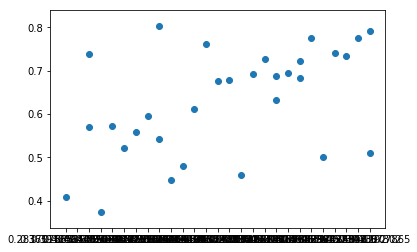

In [68]:
linR.fit(X_train,Y_train)
Y_train_pred = linR.predict(X_train)
print('Training accuracy on selected features: %.3f' % linR.score(X_train, Y_train))
Y_test_pred = linR.predict(X_test)
Train_error = linR.score(X_train, Y_train)
MAE = metrics.mean_absolute_error(Y_test, Y_test_pred)
MSE = metrics.mean_squared_error(Y_test, Y_test_pred)
RMSE = numpy.sqrt(metrics.mean_squared_error(Y_test, Y_test_pred))
R2 = metrics.r2_score(Y_test,Y_test_pred)
a= [1,Train_error,MAE,MSE,RMSE,R2]
matplot.scatter(Y_test,Y_test_pred)

In [69]:
a

[1,
 0.6208358740564957,
 0.10783702120551088,
 0.02039614102725198,
 0.14281505882522327,
 0.335827367533854]

In [70]:
Source_Scaled_0 = Source_Scaled.loc[Source_Scaled['clusters'] == 0]
Y = pandas.DataFrame(Source_Scaled_0["mpg"])
X = Source_Scaled_0.loc[:, ~Source_Scaled_0.columns.isin(['mpg','clusters'])]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=100)

Training accuracy on selected features: 0.665


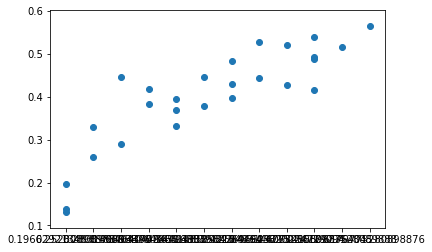

In [71]:
linR.fit(X_train,Y_train)
Y_train_pred = linR.predict(X_train)
print('Training accuracy on selected features: %.3f' % linR.score(X_train, Y_train))
Y_test_pred = linR.predict(X_test)
matplot.scatter(Y_test,Y_test_pred)
Train_error = linR.score(X_train, Y_train)
MAE = metrics.mean_absolute_error(Y_test, Y_test_pred)
MSE = metrics.mean_squared_error(Y_test, Y_test_pred)
RMSE = numpy.sqrt(metrics.mean_squared_error(Y_test, Y_test_pred))
R2 = metrics.r2_score(Y_test,Y_test_pred)
b= [0,Train_error,MAE,MSE,RMSE,R2]

In [72]:
b

[0,
 0.6647250707918809,
 0.050399366947377074,
 0.004072486488715888,
 0.06381603629743772,
 0.6432885455772557]

In [73]:
Source_Scaled_2 = Source_Scaled.loc[Source_Scaled['clusters'] == 2]
Y = pandas.DataFrame(Source_Scaled_2["mpg"])
X = Source_Scaled_2.loc[:, ~Source_Scaled_2.columns.isin(['mpg','clusters'])]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=100)

Training accuracy on selected features: 0.740


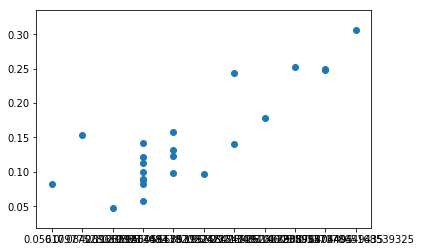

In [74]:
linR.fit(X_train,Y_train)
Y_train_pred = linR.predict(X_train)
print('Training accuracy on selected features: %.3f' % linR.score(X_train, Y_train))
Y_test_pred = linR.predict(X_test)
matplot.scatter(Y_test,Y_test_pred)
Train_error = linR.score(X_train, Y_train)
MAE = metrics.mean_absolute_error(Y_test, Y_test_pred)
MSE = metrics.mean_squared_error(Y_test, Y_test_pred)
RMSE = numpy.sqrt(metrics.mean_squared_error(Y_test, Y_test_pred))
R2 = metrics.r2_score(Y_test,Y_test_pred)
c= [2,Train_error,MAE,MSE,RMSE,R2]

In [75]:
c

[2,
 0.7396342593298362,
 0.034993156726145544,
 0.0018259390635758039,
 0.042731008220913816,
 0.6936509990932169]

In [76]:
Source_Scaled_3 = Source_Scaled.loc[Source_Scaled['clusters'] == 3]
Y = pandas.DataFrame(Source_Scaled_3["mpg"])
X = Source_Scaled_3.loc[:, ~Source_Scaled_3.columns.isin(['mpg','clusters'])]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=100)

Training accuracy on selected features: 0.780


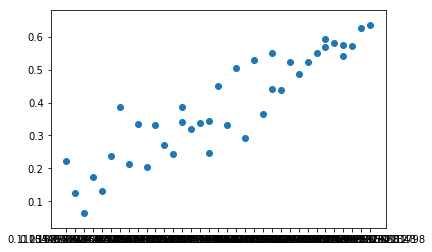

In [77]:
linR.fit(X_train,Y_train)
Y_train_pred = linR.predict(X_train)
print('Training accuracy on selected features: %.3f' % linR.score(X_train, Y_train))
Y_test_pred = linR.predict(X_test)
matplot.scatter(Y_test,Y_test_pred)
Train_error = linR.score(X_train, Y_train)
MAE = metrics.mean_absolute_error(Y_test, Y_test_pred)
MSE = metrics.mean_squared_error(Y_test, Y_test_pred)
RMSE = numpy.sqrt(metrics.mean_squared_error(Y_test, Y_test_pred))
R2 = metrics.r2_score(Y_test,Y_test_pred)
d= [3,Train_error,MAE,MSE,RMSE,R2]

In [78]:
d

[3,
 0.7797898841867865,
 0.06081137693477262,
 0.005809232960758541,
 0.0762183243108804,
 0.7896219715068309]

In [79]:
Y = pandas.DataFrame(Source_Scaled["mpg"])
X = Source_Scaled.loc[:, ~Source_Scaled.columns.isin(['mpg','clusters'])]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=100)

Training accuracy on selected features: 0.808


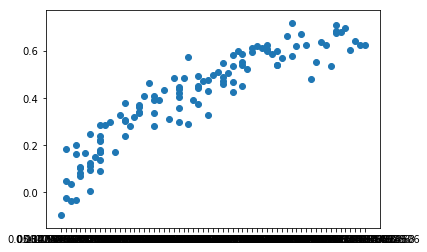

In [80]:
linR.fit(X_train,Y_train)
Y_train_pred = linR.predict(X_train)
print('Training accuracy on selected features: %.3f' % linR.score(X_train, Y_train))
Y_test_pred = linR.predict(X_test)
matplot.scatter(Y_test,Y_test_pred)
Train_error = linR.score(X_train, Y_train)
MAE = metrics.mean_absolute_error(Y_test, Y_test_pred)
MSE = metrics.mean_squared_error(Y_test, Y_test_pred)
RMSE = numpy.sqrt(metrics.mean_squared_error(Y_test, Y_test_pred))
R2 = metrics.r2_score(Y_test,Y_test_pred)
e= ['All',Train_error,MAE,MSE,RMSE,R2]

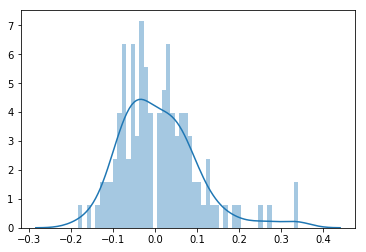

In [81]:
sns.distplot((Y_test-Y_test_pred),bins=50);

In [82]:
LinR_Results = pandas.DataFrame([a,b,c,d,e], columns=['Cluster group','Train_Acc','MAE','MSE','RMSE','R2'], index=['Model Results C1','Model Results C0','Model Results C2','Model Results C3','Model Results w/o cluster'])

In [83]:
LinR_Results

,Cluster group,Train_Acc,MAE,MSE,RMSE,R2
Model Results C1,1,0.620836,0.107837,0.020396,0.142815,0.335827
Model Results C0,0,0.664725,0.050399,0.004072,0.063816,0.643289
Model Results C2,2,0.739634,0.034993,0.001826,0.042731,0.693651
Model Results C3,3,0.779790,0.060811,0.005809,0.076218,0.789622
Model Results w/o cluster,All,0.808458,0.070166,0.008441,0.091873,0.821073


Observations :
    
1. As noticed above in the results, model with all variables without cluster split is giving the best result. This could be because of the ensembling effect in data. 
2. The model for cluster 1 seems to perform poorly compared to others. Need more data or features to understand why this has gone down
3. Individual clusters models are not performing well. This could be because the clusters are not very hetrogenous.
4. Ensembles may improve the score further